In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
import os
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

In [2]:
##############define file names
sg_table_filename = "elife-19760-supp3-v2.1.csv"
sel_genes_filename = "genes_cat.txt"

#####################################

#####################################

#####pick top three ranked protospacer sequences
def pick_top3(rank):
    if((rank==1)or(rank==2)or(rank==3)):
        return(1)
    else:
        return(0)
######read in files
sel_genes = pd.read_csv(sel_genes_filename,sep='\t',header=None)
sg_table = pd.read_csv(sg_table_filename,sep=',')
sg_table = sg_table.drop([0,1,2,3,4,5,6,7,8],axis=0)
sg_table = sg_table[['sgID','gene','transcript','protospacer sequence','selection rank','predicted score','empirical score']]
#####merge by searching selected genes
sg_select = pd.merge(sel_genes,sg_table,left_on=0,right_on='gene')
#####select top 3 genes
sg_select['in_top'] = sg_select.apply(lambda row: pick_top3(row['selection rank']),axis=1)
sg_select = sg_select[sg_select['in_top']==1]
#####for those with duplicates, take only P1 (primary predicted TSS)
sg_select = sg_select[sg_select['transcript']!='P2']
print("number of sgRNAs:")
print(sg_select.shape[0])
#####print number of genes found with guides
tmp = sg_select[0]
tmp = tmp.drop_duplicates()
print("number of genes:")
print(tmp.shape[0])
####save
sg_select = sg_select.drop([0],axis=1)
sg_select.to_csv('top3.csv',sep=',',header=None,index=None)

number of sgRNAs:
219
number of genes:
73


/usr/local/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
####replace algorithm score by empirical score if empirical score exists
def replace_vals(val_1,val_2):
    if pd.isnull(val_1):
        return(val_2)
    else: 
        return(val_1)
    
######import top3 sgRNAs for each gene
top3 = pd.read_csv("top3.csv",sep=',',header=None)
######apply replace_vals fn
top3[9] = top3.apply(lambda row: replace_vals(row[6],row[5]),axis=1)
######col 9 is the final concatenated scores
top3.head()

,0,1,2,3,4,5,6,7,9
0,KCNQ5_+_73331832.23-P1P2,KCNQ5,P1P2,GGCGCCGGCGGGTTTCAAGG,1,NaN,1.079527,1,1.079527
1,KCNQ5_+_73331813.23-P1P2,KCNQ5,P1P2,GAGGAAGCCGGCGGCCGACG,2,NaN,0.965065,1,0.965065
2,KCNQ5_-_73331986.23-P1P2,KCNQ5,P1P2,GTGGGTGAAGAgcggcgcag,3,0.931226,NaN,1,0.931226
3,TGFBR2_+_30648154.23-P1P2,TGFBR2,P1P2,GCGGCCGAGGGAAGCTGCAC,1,0.886507,NaN,1,0.886507
4,TGFBR2_-_30648144.23-P1P2,TGFBR2,P1P2,GGCGTGCACCCGCTCGGGAC,2,0.814582,NaN,1,0.814582


percentile cutoff
0
percentile value
0.373384095


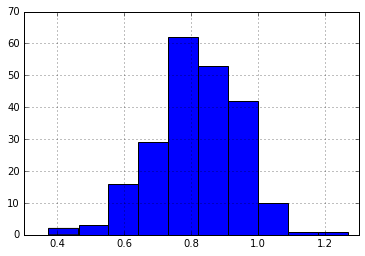

In [4]:
####graph distribution of scores
top3[9].hist()
####determine percentile value
pct_cutoff = 0
pct = np.percentile(top3[9],pct_cutoff)
##print
print("percentile cutoff")
print(pct_cutoff)
print("percentile value")
print(pct)

In [5]:
#####cutoff top3 table by percentile value
##print
print("guides before pct cutoff")
print(top3.shape[0])
#######cutoff
top3 = top3[top3[9]>= 0]
##print
print("guides after pct cutoff")
print(top3.shape[0])
#####determine number of genes remaining with 3 guides per gene
tmp_genes = top3[1]
tmp_genes.to_csv('tmp_genes',sep='\t',header=None,index=None)
cmd = 'sort tmp_genes | uniq -c > tmp_uniq.out'
os.system(cmd)
tmp_uniq = pd.read_csv('tmp_uniq.out',header=None,sep=' ')
tmp_uniq = tmp_uniq[[6,7]]
print("num of genes remaining")
tmp_remain = tmp_uniq[tmp_uniq[6]>2].shape
print(tmp_remain[0])
######remove tmp files
os.system("rm tmp*")
######keep only those with 3 guides per gene
tmp_uniq = pd.DataFrame(tmp_uniq[tmp_uniq[6]>2][7])
tmp_uniq = pd.merge(tmp_uniq,top3,left_on=7,right_on=1)
print('num of guides left')
print(tmp_uniq.shape[0])
###format
tmp_uniq = tmp_uniq.drop(['7_x','7_y',5,6,7,0,9,2],axis=1)

guides before pct cutoff
219
guides after pct cutoff
219
num of genes remaining
73
num of guides left
219


In [6]:
#########add in negative controls
######define negative controls sequence files
negfile_name = "negatives.txt"
negfile_num = 3
#####################################

#####################################
negfile = open(negfile_name, "r")
tmp = negfile.read().split('\n')
negs_seq = []
negs_name = []
negs_num = []
for i in range(negfile_num):
    negs_seq.append(tmp[i])
    negs_name.append('neg')
    negs_num.append(i+1)
###append onto dataframe
d = {1: negs_name, 3: negs_seq, 4:negs_num}
negs = pd.DataFrame(data=d)

tmp_uniq = pd.concat([tmp_uniq,negs])

In [7]:
tmp_uniq

,1,3,4
0,COL14A1,GAGCGCAGCGGCagaaggag,1
1,COL14A1,GGCCGCCAAGGACCAACTAG,2
2,COL14A1,GCTCCGAGGGAAGAGAGCAA,3
3,COL1A1,GTCCTCGGGGTCGGAGCAGG,1
4,COL1A1,GGCCAGTCGTCGGAGCAGAC,2
5,COL1A1,GGTGTGAGGCCACGCATGAG,3
6,COL1A2,GCGGCGGAGGTATCACCTGG,1
7,COL1A2,GCACCGGCGGAGGTATCACC,2
8,COL1A2,GACCTCCGCCGGTGACCCAG,3
9,COL3A1,GTGACGGGCCCGGTGCTGAA,1


In [8]:
######generate cloning oligos from protospacer sequences
###
adapterF = "CTTCTACCGAACATACAGccac"
adapterR = "gctgTCGCGTTATGCTGTATGT"
adaptor_setID = "8"
###
digestLeft = "CTTGTTG"
digestRight = "gtttaagaGCTAA"
tmp_uniq['seq'] = tmp_uniq.apply(lambda row: adapterF+digestLeft+row[3]+digestRight+adapterR,axis=1)
######save file
tmp_uniq.to_csv('top3_final.csv',sep=',',header=None)
tmp_uniq.head()
######save as fasta
####get ids
libfile_id1 = tmp_uniq[1].tolist()
libfile_id2 = tmp_uniq[4].tolist()
libfile_id = []
for index in range(len(libfile_id1)):
    libfile_id.append(libfile_id1[index] + "_" + str(libfile_id2[index]))
####get seqs
libfile_seq = tmp_uniq['seq'].tolist()
####read into seqrecord
libfile = []
for index in range(len(libfile_id)):
    record = SeqRecord(Seq(libfile_seq[index]),id=libfile_id[index],description="")
    libfile.append(record)
#######write out library to file
libfile_name = "libfile_adaptorset_"+adaptor_setID+".fa"
SeqIO.write(libfile, libfile_name, "fasta")

222